# Loan Grade, Sub-Grade and Interest Rate Prediction

**Table of contents**<a id='toc0_'></a>    
- [Setup](#toc1_)    
  - [Imports and Settings](#toc1_1_)    
  - [Data Preparation](#toc1_2_)    
    - [Oversampling](#toc1_2_1_)    
    - [Data Cleaning](#toc1_2_2_)    
  - [Feature Engineering](#toc1_3_)    
- [Grade Prediction](#toc2_)    
  - [Single Applications](#toc2_1_)    
    - [Pipeline Construction](#toc2_1_1_)    
    - [Feature selection](#toc2_1_2_)    
    - [Hyperparameter Tuning](#toc2_1_3_)    
    - [Model Selection](#toc2_1_4_)    
  - [Joint Applications](#toc2_2_)    
    - [Pipeline](#toc2_2_1_)    
    - [Feature removal](#toc2_2_2_)    
    - [Hyperparameter tuning](#toc2_2_3_)    
- [Sub-grade Prediction](#toc3_)    
  - [Single Application Sub-Grade Model](#toc3_1_)    
    - [Pipelines](#toc3_1_1_)    
    - [Hyperparameter Tuning](#toc3_1_2_)    
    - [Model Selection](#toc3_1_3_)    
  - [Joint Application Sub-grade Model](#toc3_2_)    
    - [Pipeline](#toc3_2_1_)    
    - [Hyperparameter tuning](#toc3_2_2_)    
- [Interest Rate Prediction](#toc4_)    
  - [Single Application Interest Rate Model](#toc4_1_)    
    - [Pipeline](#toc4_1_1_)    
    - [Hyperparameter Tuning](#toc4_1_2_)    
  - [Joint Application Interest Rate Model](#toc4_2_)    
    - [Pipeline](#toc4_2_1_)    
    - [Hyperparameter tuning](#toc4_2_2_)    
- [Testing](#toc5_)    
  - [Time-wise analysis](#toc5_1_)    
  - [Feature importance based on SHAP values](#toc5_2_)    
  - [Final Testing and Exports](#toc5_3_)    
    - [Single Application Grade Model](#toc5_3_1_)    
    - [Joint Application Grade model](#toc5_3_2_)    
    - [Single Application Sub-Grade Model](#toc5_3_3_)    
    - [Joint Application Sub-Grade Model](#toc5_3_4_)    
    - [Single Application Interest Rate Model](#toc5_3_5_)    
    - [Joint Application Interest Rate Model](#toc5_3_6_)    
    - [Testing Overview](#toc5_3_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=4
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_'></a>[Setup](#toc0_)

### <a id='toc1_1_'></a>[Imports and Settings](#toc0_)

**Imports:**

In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from sklearn.metrics import mean_squared_error
from pprint import pprint
from ray import tune
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
from functions.transformers import PolarsColumnTransformer as PCT
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.statistics as st
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,f1_score
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering
%aimport functions.statistics

**Settings:**

In [2]:
ALPHA = 0.05
BASE_FIG_SIZE = (8.5, 4.5)
sns.set()


### <a id='toc1_2_'></a>[Data Preparation](#toc0_)

**Loading the data:**

In [3]:
data_train_single = pl.read_parquet("data/data_accepted_single_train.parquet")
data_val_single = pl.read_parquet("data/data_accepted_single_val.parquet")
data_test_single = pl.read_parquet("data/data_accepted_single_test.parquet")
data_train_joint = pl.read_parquet("data/data_accepted_joint_train.parquet")
data_val_joint = pl.read_parquet("data/data_accepted_joint_val.parquet")
data_test_joint = pl.read_parquet("data/data_accepted_joint_test.parquet")


#### <a id='toc1_2_1_'></a>[Oversampling](#toc0_)

**Sub-grades with the lowest representation in single applications:**

In [4]:
data_train_single["sub_grade"].value_counts().sort("counts")[:10]


sub_grade,counts
str,u32
"""G5""",873
"""G4""",1021
"""G3""",1447
"""G2""",2003
"""G1""",2637
"""F5""",3770
"""F4""",4773
"""F3""",6078
"""F2""",7532


**Sub-grades with the lowest representation in joint applications:**

In [5]:
data_train_joint["sub_grade"].value_counts().sort("counts")[:10]


sub_grade,counts
str,u32
"""G2""",78
"""G3""",79
"""G4""",79
"""G5""",90
"""F4""",154
"""G1""",171
"""F2""",185
"""F5""",187
"""F3""",253


**Oversampling the classes with the lowest representation in the training set:**

In [6]:
data_train_single = data_train_single.vstack(
    st.oversample_polars(data_train_single, "sub_grade", 10000)
)
data_train_joint = data_train_joint.vstack(
    st.oversample_polars(data_train_joint, "sub_grade", 500)
)


Rare classes were over-sampled in the training set so that no sub-grade is rarer than 10000 samples in the single application set and 500 in the joint application set.

**Saving the dates for the data:**

In [7]:
dates_train = data_train_single["issue_d"]
dates_val = data_val_single["issue_d"]
dates_test = data_test_single["issue_d"]


#### <a id='toc1_2_2_'></a>[Data Cleaning](#toc0_)

**Cleaning the data:**

In [8]:
data_train_single = dmf.clean_accepted_single(data_train_single)
data_val_single = dmf.clean_accepted_single(data_val_single)
data_test_single = dmf.clean_accepted_single(data_test_single)
data_train_joint = dmf.clean_accepted_joint(data_train_joint)
data_val_joint = dmf.clean_accepted_joint(data_val_joint)
data_test_joint = dmf.clean_accepted_joint(data_test_joint)


**Dropping Features based on EDA:**

In [9]:
data_train_single = dmf.remove_poor_features_single(data_train_single)
data_val_single = dmf.remove_poor_features_single(data_val_single)
data_test_single = dmf.remove_poor_features_single(data_test_single)
data_train_joint = dmf.remove_poor_features_joint(data_train_joint)
data_val_joint = dmf.remove_poor_features_joint(data_val_joint)
data_test_joint = dmf.remove_poor_features_joint(data_test_joint)


### <a id='toc1_3_'></a>[Feature Engineering](#toc0_)

**Adding and modifying features:**

In [10]:
data_train_single = feats.date_features(data_train_single, "issue_d")
data_val_single = feats.date_features(data_val_single, "issue_d")
data_test_single = feats.date_features(data_test_single, "issue_d")
data_train_joint = feats.date_features_joint(data_train_joint, "issue_d")
data_val_joint = feats.date_features_joint(data_val_joint, "issue_d")
data_test_joint = feats.date_features_joint(data_test_joint, "issue_d")


The following date features were changed:
1. The month of the year was changed into it's sine and cosine transformations.
2. Earliest credit line and last credit line was transformed to represent the day difference from the current date.
3. Current year was extracted from the date.

**Labeling grades with a sequence of numbers:**

In [11]:
data_train_single = dmf.label_target_grades(
    data_train_single,
)
data_val_single = dmf.label_target_grades(
    data_val_single,
)
data_test_single = dmf.label_target_grades(data_test_single)
data_train_joint = dmf.label_target_grades(
    data_train_joint,
)
data_val_joint = dmf.label_target_grades(
    data_val_joint,
)
data_test_joint = dmf.label_target_grades(data_test_joint)


**Specifying dependent and independent variables:**

In [12]:
X_train_single = data_train_single.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d"]
)
y_train_single = data_train_single["grade"]

X_val_single = data_val_single.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d"]
)
y_val_single = data_val_single["grade"]

X_train_joint = data_train_joint.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d"]
)
y_train_joint = data_train_joint["grade"]

X_val_joint = data_val_joint.drop(columns=["grade", "sub_grade", "int_rate", "issue_d"])
y_val_joint = data_val_joint["grade"]

X_test_single = data_test_single.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d"]
)
y_test_single = data_test_single["grade"]

X_test_joint = data_test_joint.drop(
    columns=["grade", "sub_grade", "int_rate", "issue_d"]
)
y_test_joint = data_test_joint["grade"]

**Specifying targets:**

In [13]:
data_train_single = dmf.label_target_sub_grades(
    data_train_single,
)
data_val_single = dmf.label_target_sub_grades(
    data_val_single,
)
data_test_single = dmf.label_target_sub_grades(data_test_single)
data_train_joint = dmf.label_target_sub_grades(
    data_train_joint,
)
data_val_joint = dmf.label_target_sub_grades(
    data_val_joint,
)
data_test_joint = dmf.label_target_sub_grades(data_test_joint)

y_train_single_subgrade = data_train_single["sub_grade"]
y_val_single_subgrade = data_val_single["sub_grade"]
y_test_single_subgrade = data_test_single["sub_grade"]
y_train_joint_subgrade = data_train_joint["sub_grade"]
y_val_joint_subgrade = data_val_joint["sub_grade"]
y_test_joint_subgrade = data_test_joint["sub_grade"]

y_train_single_intr = data_train_single["int_rate"]
y_val_single_intr = data_val_single["int_rate"]
y_test_single_intr = data_test_single["int_rate"]
y_train_joint_intr = data_train_joint["int_rate"]
y_val_joint_intr = data_val_joint["int_rate"]
y_test_joint_intr = data_test_joint["int_rate"]


## <a id='toc2_'></a>[Grade Prediction](#toc0_)

### <a id='toc2_1_'></a>[Single Applications](#toc0_)

#### <a id='toc2_1_1_'></a>[Pipeline Construction](#toc0_)

**Adding imputers:**

In [14]:
preprocess_single = Pipeline([])
emp_title_imp = tr.NotInImputerPolars(cat_no=20, fill_value="other")
emp_length_imp = tr.NotInImputerPolars(cat_no=12, fill_value=None)
zip_imp = tr.NotInImputerPolars(cat_no=50, fill_value="other")
imputers = PCT(
    [
        PCT.Step("emp_title", emp_title_imp, "emp_title"),
        PCT.Step("emp_length", emp_length_imp, "emp_length"),
        PCT.Step("zip_code", zip_imp, "zip_code"),
    ]
)
preprocess_single.steps.append(("imputers", imputers))


Features with a high number of distinct categories, such as "employment title" and "zip code," underwent a modification process using the "NotInImputer" technique. This method retains a predetermined quantity of the most frequently occurring values within these features while replacing all other less common values with a specific designated value. 

**Adding encoders:**

In [15]:
emp_t_enc = tr.TargetMeanOrderedLabeler(how="label")
emp_l_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
emp_l_enc = tr.PolarsOrdinalEncoder(order=emp_l_order)
home_enc = tr.TargetMeanOrderedLabeler(how="label")
verif_enc = tr.TargetMeanOrderedLabeler(how="label")
paymnt_enc = tr.PolarsOneHotEncoder(drop=True)
purpose_enc = tr.TargetMeanOrderedLabeler(how="label")
zip_enc = tr.TargetMeanOrderedLabeler(how="label")
state_enc = tr.TargetMeanOrderedLabeler(how="label")
init_stat_enc = tr.PolarsOneHotEncoder(drop=True)
disbursement_enc = tr.PolarsOneHotEncoder(drop=True)
year_enc = tr.TargetMeanOrderedLabeler(how="last_mean")

encoders = PCT(
    [
        PCT.Step("emp_t_enc", emp_t_enc, "emp_title"),
        PCT.Step("emp_l_enc", emp_l_enc, "emp_length"),
        PCT.Step("home_enc", home_enc, "home_ownership"),
        PCT.Step("verif_enc", verif_enc, "verification_status"),
        PCT.Step("paymnt_enc", paymnt_enc, "pymnt_plan"),
        PCT.Step("purpose_enc", purpose_enc, "purpose"),
        PCT.Step("zip_enc", zip_enc, "zip_code"),
        PCT.Step("state_enc", state_enc, "addr_state"),
        PCT.Step("init_stat_enc", init_stat_enc, "initial_list_status"),
        PCT.Step("disbursement_enc", disbursement_enc, "disbursement_method"),
        PCT.Step("year_enc", year_enc, "year"),
    ]
)

preprocess_single.steps.append(("encoders", encoders))
null_imp = tr.PolarsNullImputer(fill_value=-9)
preprocess_single.steps.append(("null_imputer", null_imp))


A variety of encoding techniques were applied to handle categorical features within the dataset:

1. **One-Hot Encoding for Two-Category Features:** Two-category features were encoded using a one-hot encoding approach, resulting in a single Boolean column.

2. **Label Encoding for Inherently Unordered Categorical Data:** For inherently unordered categorical data, a label encoder was utilized. This method imparts an order to the unordered categories by calculating and the target mean and arranging the labels in accordance.

3. **Ordered Labeling for Inherently Ordered Categories:** Categories with inherent ordering, such as "employment length," were encoded using a predefined ordered labeling scheme.

4. **Encoding Current Year with Mean Interest Rate:** To encode the current year, an encoder was employed that assigns the mean interest rate from the previous year. This helps incorporate historical interest rate data into the feature.

For any remaining null values, they were substituted with the value -9 to ensure compatibility with BorutaPy, as decision-tree-based algorithms interpret this value differently, given that all other data is positive.

**Specifying the model:**

In [16]:
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=6,
)


#### <a id='toc2_1_2_'></a>[Feature selection](#toc0_)

**Getting lists of selected features based on boruta algorithm with different strictness:**

**Getting lists of columns to drop:**

In [17]:
cols_to_drop_space = joblib.load("temp/cols_to_drop.joblib")


**Adding a feature removal step:**

In [18]:
feature_dropper = tr.FeatureRemover([])
preprocess_single.steps.append(("feature_dropper", feature_dropper))
full_pipeline_single = Pipeline(
    [("preprocess", preprocess_single), ("model", model_single_lgbm)]
)


Incorporating BorutaPy directly into the pipeline proved to be impractical due to the substantial slowdown it introduced in each training iteration, particularly when the dataset featured a significant number of features. To address this issue, an alternative approach was adopted:

Several trials were conducted using different Boruta algorithm stringency settings on a sample of the data. In each trial, the selected features were identified and extracted into a list of collections of columns to be removed. This list of feature removal specifications is subsequently employed within a custom FeatureRemover transformer, allowing for manual control and tuning.

#### <a id='toc2_1_3_'></a>[Hyperparameter Tuning](#toc0_)

**Baseline for tuning:**

In [19]:
full_pipeline_single.fit(
    X_train_single.sample(100000, seed=1), y_train_single.sample(100000, seed=1)
)
preds = full_pipeline_single.predict(X_val_single)
print(f1_score(y_val_single, preds, average="macro"))


0.32921260768360766


A baseline for the untuned model was established to serve as a benchmark for the early stopping of tuning trials.

##### Parameter Search Space

**LightGBM:**

In [20]:
models = tunes.Models()
search_space_lgbm = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__max_depth": tune.randint(5, 50),
    "model__num_leaves": tune.randint(10, 3051),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models.add_model(
    "lgbm_grade_single", full_pipeline_single, search_space_lgbm, metric_threshold=0.35
)


**Decision Tree:**

In [21]:
preprocess_single_dtree = copy.deepcopy(preprocess_single)
model_single_dtree = DecisionTreeClassifier(random_state=1)
full_pipeline_single_dtree = Pipeline(
    [("preprocess", preprocess_single_dtree), ("model", model_single_dtree)]
)

search_space_tree = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
}

models.add_model(
    "tree_grade_single",
    full_pipeline_single_dtree,
    search_space_tree,
    metric_threshold=0.3,
    override_n=120,
)


In addition to the LightGBM model, a single decision tree model was included for the purpose of comparison. These models, along with their respective parameter configurations, were organized and managed within a dedicated "model holder" class. 

##### Parameter Tuning

In [22]:
models = joblib.load("temp/tuned_grade_models.joblib")


The models were fine-tuned using the macro average of the F1 score as the primary evaluation criterion. This particular metric was selected because it places a strong emphasis on achieving a balanced and effective separation of all classes within the dataset, making it a robust measure of model performance across multiple categories or classes.

##### Tuning Results

**Best parameters for each model:**

In [23]:
for model in models.models.values():
    pprint(model.name)
    pprint(
        {
            key: value
            for key, value in model.best_params.items()
            if key != "preprocess__feature_dropper__feats_to_drop"
        }
    )

'lgbm_grade_single'
{'model__bagging_freq': 9,
 'model__boosting_type': 'gbdt',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.6849549665551705,
 'model__learning_rate': 0.0558509334178991,
 'model__max_bin': 40,
 'model__max_depth': 33,
 'model__n_estimators': 204,
 'model__num_leaves': 2051,
 'model__reg_alpha': 0.0010009764783985519,
 'model__reg_lambda': 43.90677880592865,
 'model__subsample': 0.9796606370081837}
'tree_grade_single'
{'model__class_weight': None,
 'model__criterion': 'entropy',
 'model__max_depth': 11,
 'model__max_features': None,
 'model__splitter': 'random'}


**Number of features removed in each model:**

In [24]:
for model in models.models.values():
    pprint(model.name)
    pprint(len(model.best_params["preprocess__feature_dropper__feats_to_drop"]))

'lgbm_grade_single'
40
'tree_grade_single'
57


The Gradient Boosting Decision Tree (GBDT) algorithm was identified as the most suitable choice. The best LightGBM model exhibited specific hyperparameters:

1. A large number of minimum leaves: The model employed 2050 minimum leaves, indicating a relatively complex tree structure.

2. Feature Removal: A total of 40 features were removed from the dataset as part of the feature selection process.

3. Slow Learning Rate: A learning rate of 0.06 was utilized.

4. A Large Number of Estimators: The model employed 204 estimators.


#### <a id='toc2_1_4_'></a>[Model Selection](#toc0_)

**Testing the models:**

In [25]:
models.models["lgbm_grade_single"].pipeline["model"].set_params(**{"num_threads": 6})
for model in models.models.values():
    model.pipeline.fit(X_train_single, y_train_single)

preds_lgbm = models.models["lgbm_grade_single"].pipeline.predict(X_val_single)
preds_dtree = models.models["tree_grade_single"].pipeline.predict(X_val_single)
print(classification_report(y_val_single, preds_lgbm))
print(classification_report(y_val_single, preds_dtree))


              precision    recall  f1-score   support

           1       0.65      0.71      0.68     72529
           2       0.48      0.55      0.51    121365
           3       0.52      0.35      0.42    130148
           4       0.26      0.30      0.28     50567
           5       0.17      0.28      0.21     17982
           6       0.14      0.20      0.16      5509
           7       0.26      0.02      0.03      3054

    accuracy                           0.46    401154
   macro avg       0.35      0.34      0.33    401154
weighted avg       0.48      0.46      0.46    401154

              precision    recall  f1-score   support

           1       0.60      0.64      0.62     72529
           2       0.43      0.54      0.48    121365
           3       0.45      0.51      0.48    130148
           4       0.25      0.06      0.10     50567
           5       0.16      0.04      0.06     17982
           6       0.17      0.04      0.06      5509
           7       0.08 

Both the decision tree and the LightGBM model achieved an identical accuracy of 46%. However, the LightGBM model outperformed the decision tree in terms of average precision and recall. This indicates that the LightGBM model exhibits a better ability to distinguish and classify the rarer classes within the dataset, therefore it was chosen as the better model.

In [26]:
best_pipeline_single = models.models["lgbm_grade_single"].pipeline


### <a id='toc2_2_'></a>[Joint Applications](#toc0_)

#### <a id='toc2_2_1_'></a>[Pipeline](#toc0_)

**Setting up joint application preprocessing:**

In [27]:
imputers_joint = copy.deepcopy(imputers)
encoders_joint = copy.deepcopy(encoders)
encoders_to_delete = ["disbursement_enc", "paymnt_enc"]

for key in encoders_to_delete:
    del encoders_joint.steps[key]

verif_enc_joint = tr.TargetMeanOrderedLabeler(how="label")

encoders_joint.steps["verif_enc_joint"] = PCT.Step(
    "verif_enc_joint", verif_enc_joint, "verification_status_joint"
)

null_imp_joint = copy.deepcopy(null_imp)
feature_dropper_joint = tr.FeatureRemover([])

preprocess_joint = Pipeline(
    [
        ("imputers", imputers_joint),
        ("encoders", encoders_joint),
        ("null_imputer", null_imp_joint),
        ("feature_dropper", feature_dropper_joint),
    ]
)

model_joint = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=12,
)

full_pipeline_joint = Pipeline(
    [("preprocess", preprocess_joint), ("model", model_joint)]
)

#### <a id='toc2_2_2_'></a>[Feature removal](#toc0_)

**Gathering the lists of important features using the Boruta Algorithm:**

**Creating lists of columns to remove:**

In [28]:
cols_to_drop_space_joint = joblib.load("temp/cols_to_drop_joint.joblib")


#### <a id='toc2_2_3_'></a>[Hyperparameter tuning](#toc0_)

**Parameter space:**

In [29]:
search_space_lgbm_joint = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space_joint),
    "model__max_depth": tune.randint(5, 40),
    "model__num_leaves": tune.randint(10, 2500),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

joint_grade_classifier = tunes.Models.Model(
    "joint_grade_lgbm",
    pipeline=full_pipeline_joint,
    param_grid=search_space_lgbm_joint,
    metric_threshold=0.3,
)

joint_grade_classifier.pipeline["model"].set_params(**{"num_threads": 1})


LGBMClassifier(class_weight='balanced', force_col_wise=True, num_threads=1,
               objective='multiclass', random_state=1, verbose=-1)

**Tuning the parameters:**

In [30]:
joint_grade_classifier = joblib.load("temp/tuned_joint_grade.joblib")


**The best parameters:**

In [31]:
joint_grade_classifier.best_params

{'preprocess__feature_dropper__feats_to_drop': [],
 'model__max_depth': 23,
 'model__num_leaves': 1914,
 'model__n_estimators': 188,
 'model__learning_rate': 0.07073565588841094,
 'model__bagging_freq': 6,
 'model__colsample_bytree': 0.5167584359479642,
 'model__subsample': 0.8708296688477901,
 'model__reg_alpha': 12.533291967833335,
 'model__reg_lambda': 0.00745184747969614,
 'model__boosting_type': 'gbdt',
 'model__class_weight': None,
 'model__max_bin': 48}

The Gradient Boosting Decision Tree (GBDT) algorithm implemented with LightGBM was chosen as the best algorithm for joint applications. It's interesting that no features were dropped, and a significant alpha regularization parameter was chosen, indicating that feature selection was accomplished primarily through regularization rather than explicit feature dropping.

Introducing a time-wise performance penalty to the tuning process would be interesting. This approach can encourage the model to prefer feature dropping over heavy regularization when performance is too slow.

**Testing the model on the validation set:**

In [32]:
joint_grade_classifier.pipeline["model"].set_params(**{"num_threads": 12})
joint_grade_classifier.pipeline.fit(X_train_joint, y_train_joint)
preds_joint_grade = joint_grade_classifier.pipeline.predict(X_val_joint)
print(classification_report(y_val_joint, preds_joint_grade))


              precision    recall  f1-score   support

           1       0.80      0.69      0.74      6153
           2       0.52      0.55      0.54      8269
           3       0.44      0.67      0.53      8318
           4       0.42      0.17      0.25      4926
           5       0.38      0.15      0.21      1511
           6       0.24      0.17      0.20       488
           7       0.10      0.05      0.07       137

    accuracy                           0.52     29802
   macro avg       0.41      0.35      0.36     29802
weighted avg       0.53      0.52      0.51     29802



The observation that the joint application model achieved a higher accuracy despite having significantly less data for training is likely attributable to the nature of joint applications. Joint applications are often associated with a higher creditworthiness or credit grade, which can make them easier to classify as they tend to exhibit more favorable characteristics.

However, it's worth noting that the model's difficulty in correctly identifying the lowest grade loans is a significant limitation.

## <a id='toc3_'></a>[Sub-grade Prediction](#toc0_)

**Setting up the target variables:**

### <a id='toc3_1_'></a>[Single Application Sub-Grade Model](#toc0_)

#### <a id='toc3_1_1_'></a>[Pipelines](#toc0_)

**Setting up the pipelines:**

In [33]:
preprocess_single_subgrade_cl = copy.deepcopy(preprocess_single)
preprocess_single_subgrade_rg = copy.deepcopy(preprocess_single)

model_single_sg_cl = lgb.LGBMClassifier(
    objective="multiclass",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=1,
)

model_single_sg_rg = lgb.LGBMRegressor(
    verbose=-1, force_col_wise=True, random_state=1, num_threads=1
)
regressor_wraper_single = tr.ModelWrapper(model_single_sg_rg)

sub_grade_rounder = tr.RoundToRangeTransformer(1, 35)
pipeline_single_sg_cl = Pipeline(
    [("preprocess", preprocess_single_subgrade_cl), ("model", model_single_sg_cl)]
)
pipeline_single_sg_rg = Pipeline(
    [
        ("preprocess", preprocess_single_subgrade_rg),
        ("model", regressor_wraper_single),
        ("rounding", sub_grade_rounder),
    ]
)


Two models were compared for subgrade prediction: first, the LightGBM classifier, and second, the LightGBM regressor. Since subgrades consist of 35 ordinal values in total, it was deemed feasible to treat the prediction as a regression task. An additional post-processing rounding function was introduced into the regressor pipeline to round the predictions to the nearest integer between 1 and 35. This approach combined the advantages of regression, providing more fine-grained predictions, with the interpretability and compatibility of ordinal subgrades.

#### <a id='toc3_1_2_'></a>[Hyperparameter Tuning](#toc0_)

**Search Space of the Classifier:**

In [34]:
models_sub_single = tunes.Models()
search_space_sg_cl = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__max_depth": tune.randint(5, 40),
    "model__num_leaves": tune.randint(10, 2500),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models_sub_single.add_model(
    "cl_subgrade_single",
    pipeline_single_sg_cl,
    search_space_sg_cl,
    metric_threshold=0.1,
)

**Search space of the regressor:**

In [35]:
search_space_sg_rg = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__param_grid": {
        "num_leaves": tune.randint(10, 2500),
        "max_depth": tune.randint(10, 40),
        "n_estimators": tune.randint(10, 251),
        "learning_rate": tune.loguniform(0.001, 0.1),
        "bagging_freq": tune.randint(0, 11),
        "colsample_bytree": tune.uniform(0.2, 1.0),
        "subsample": tune.uniform(0.2, 1.0),
        "reg_alpha": tune.loguniform(0.001, 100),
        "reg_lambda": tune.loguniform(0.001, 100),
        "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
        "class_weight": tune.choice(["balanced", None]),
        "max_bin": tune.randint(5, 256),
    },
}

models_sub_single.add_model(
    "rg_subgrade_single",
    pipeline_single_sg_rg,
    search_space_sg_rg,
    metric_threshold=0.1,
)


**Tuning the parameters:**

In [36]:
models_sub_single = joblib.load("temp/models_sub_single.joblib")


**Best parameters for each model:**

In [37]:
for model in models_sub_single.models.values():
    print(model.name)
    pprint(
        {
            key: value
            for key, value in model.best_params.items()
            if key != "preprocess__feature_dropper__feats_to_drop"
        }
    )
    print("\n")


cl_subgrade_single
{'model__bagging_freq': 3,
 'model__boosting_type': 'gbdt',
 'model__class_weight': 'balanced',
 'model__colsample_bytree': 0.7402382756527682,
 'model__learning_rate': 0.08034565850796604,
 'model__max_bin': 137,
 'model__max_depth': 8,
 'model__n_estimators': 231,
 'model__num_leaves': 1116,
 'model__reg_alpha': 0.0146906759526997,
 'model__reg_lambda': 6.4939727257369855,
 'model__subsample': 0.4094460840515235}


rg_subgrade_single
{'model__param_grid': {'bagging_freq': 7,
                       'boosting_type': 'gbdt',
                       'class_weight': None,
                       'colsample_bytree': 0.5469039710628041,
                       'learning_rate': 0.06445772008778562,
                       'max_bin': 242,
                       'max_depth': 21,
                       'n_estimators': 240,
                       'num_leaves': 1532,
                       'reg_alpha': 0.04228411127161317,
                       'reg_lambda': 6.398277385033161,
   

**Number of features removed in each model:**

In [38]:
for model in models_sub_single.models.values():
    print(model.name)
    pprint(len(model.best_params["preprocess__feature_dropper__feats_to_drop"]))

cl_subgrade_single
57
rg_subgrade_single
57


#### <a id='toc3_1_3_'></a>[Model Selection](#toc0_)

**Classification report of each model:**

In [39]:
preds_subgrade_single = {}
for name, model in models_sub_single.models.items():
    model.pipeline.fit(X_train_single, y_train_single_subgrade)
    preds_subgrade_single[name] = model.pipeline.predict(X_val_single)
    print(name)
    print(classification_report(y_val_single_subgrade, preds_subgrade_single[name]))


cl_subgrade_single
              precision    recall  f1-score   support

           1       0.41      0.44      0.42     15383
           2       0.17      0.23      0.20     12260
           3       0.13      0.18      0.15     13287
           4       0.11      0.18      0.14     13613
           5       0.14      0.11      0.12     17986
           6       0.19      0.14      0.16     25290
           7       0.11      0.08      0.09     22268
           8       0.09      0.25      0.13     23595
           9       0.08      0.08      0.08     21745
          10       0.12      0.09      0.10     28467
          11       0.12      0.06      0.08     29441
          12       0.10      0.08      0.09     24529
          13       0.12      0.02      0.04     24407
          14       0.12      0.03      0.04     25222
          15       0.12      0.05      0.07     26549
          16       0.05      0.07      0.06     12655
          17       0.06      0.11      0.08     11964
        

Both the model and the regressor achieved a similar, albeit very low accuracy of 11%, and they displayed identical average F1-scores. However, as subgrades follow an ordinal order, misclassifying a subgrade far away in the order should carry a greater penalty. To facilitate a more comprehensive comparison of these two models, the mean squared error is also employed as an evaluation metric. This approach accounts for the magnitude of the errors.

**Mean squared error of each model:**

In [40]:
from sklearn.metrics import mean_squared_error

for name, preds in preds_subgrade_single.items():
    print(name)
    print(f"MSE: {mean_squared_error(y_val_single_subgrade,preds)}")


cl_subgrade_single
MSE: 30.540126734371338
rg_subgrade_single
MSE: 19.811127397458332


The regressor exhibited a significantly lower Mean Squared Error (MSE), indicating its superior performance. As a result, it was selected as the preferred option for subgrade prediction.

**Visual comparison of model predictions:**

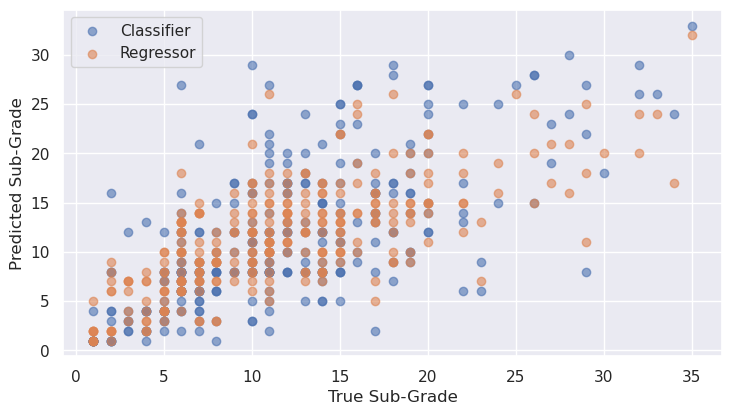

In [41]:
fig_rg_cl, ax_rg_cl = plt.subplots(figsize=BASE_FIG_SIZE)
ax_rg_cl.scatter(
    y_val_single_subgrade[:300],
    preds_subgrade_single["cl_subgrade_single"][:300],
    alpha=0.6,
    label="Classifier",
)
ax_rg_cl.scatter(
    y_val_single_subgrade[:300],
    preds_subgrade_single["rg_subgrade_single"][:300],
    alpha=0.6,
    label="Regressor",
)
ax_rg_cl.legend()
ax_rg_cl.set_xlabel("True Sub-Grade")
ax_rg_cl.set_ylabel("Predicted Sub-Grade")
plt.show()


In [42]:
best_pipeline_single_sub = models_sub_single.models["rg_subgrade_single"].pipeline


### <a id='toc3_2_'></a>[Joint Application Sub-grade Model](#toc0_)

#### <a id='toc3_2_1_'></a>[Pipeline](#toc0_)

In [43]:
preprocess_joint_sub = copy.deepcopy(preprocess_joint)
model_joint_sub = lgb.LGBMRegressor(
    verbose=-1, force_col_wise=True, random_state=1, num_threads=1
)

regressor_wraper_joint = tr.ModelWrapper(model_joint_sub)

sub_grade_rounder = tr.RoundToRangeTransformer(1, 35)

full_pipeline_joint_sub = Pipeline(
    [
        ("preprocess", preprocess_joint_sub),
        ("model", regressor_wraper_joint),
        ("rounding", sub_grade_rounder),
    ]
)


#### <a id='toc3_2_2_'></a>[Hyperparameter tuning](#toc0_)

**Search Space:**

In [44]:
search_space_sg_jt = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space_joint),
    "model__param_grid": {
        "num_leaves": tune.randint(10, 2500),
        "max_depth": tune.randint(10, 40),
        "n_estimators": tune.randint(10, 251),
        "learning_rate": tune.loguniform(0.001, 0.1),
        "bagging_freq": tune.randint(0, 11),
        "colsample_bytree": tune.uniform(0.2, 1.0),
        "subsample": tune.uniform(0.2, 1.0),
        "reg_alpha": tune.loguniform(0.001, 100),
        "reg_lambda": tune.loguniform(0.001, 100),
        "boosting_type": tune.choice(["gbdt", "dart", "rf"]),
        "class_weight": tune.choice(["balanced", None]),
        "max_bin": tune.randint(5, 256),
    },
}

joint_subgrade_classifier = tunes.Models.Model(
    "joint_subgrade_lgbm",
    pipeline=full_pipeline_joint_sub,
    param_grid=search_space_sg_rg,
)

**Hyperparameter tuning:**

In [45]:
joint_subgrade_classifier = joblib.load("temp/tuned_joint_subgrade.joblib")


**Best parameters:**

In [46]:
joint_subgrade_classifier.best_params

{'preprocess__feature_dropper__feats_to_drop': [],
 'model__param_grid': {'num_leaves': 1328,
  'max_depth': 11,
  'n_estimators': 123,
  'learning_rate': 0.09054917289383625,
  'bagging_freq': 8,
  'colsample_bytree': 0.5736133186071858,
  'subsample': 0.5468612549578166,
  'reg_alpha': 62.956344297261495,
  'reg_lambda': 0.658195653076076,
  'boosting_type': 'gbdt',
  'class_weight': 'balanced',
  'max_bin': 199}}

## <a id='toc4_'></a>[Interest Rate Prediction](#toc0_)

### <a id='toc4_1_'></a>[Single Application Interest Rate Model](#toc0_)

#### <a id='toc4_1_1_'></a>[Pipeline](#toc0_)

In [47]:
preprocess_single_intr = copy.deepcopy(preprocess_single_subgrade_rg)

model_intr_single = lgb.LGBMRegressor(
    verbose=-1, force_col_wise=True, random_state=1, num_threads=1
)

full_pipeline_single_int = Pipeline(
    [("preprocess", preprocess_single_intr), ("model", model_intr_single)]
)

The LightGBM Regressor is also used to predict interest rates.

#### <a id='toc4_1_2_'></a>[Hyperparameter Tuning](#toc0_)

**Search Space:**

In [48]:
search_space_single_int = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__num_leaves": tune.randint(10, 2500),
    "model__max_depth": tune.randint(10, 40),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 256),
}

single_intr_regressor = tunes.Models.Model(
    "lgb_single_intr", full_pipeline_single_int, search_space_single_int
)

**Hyperparameter Tuning:**

In [49]:
single_intr_regressor = joblib.load("temp/tuned_single_intr.joblib")


**Best parameters:**

In [50]:
single_intr_regressor.best_params

{'preprocess__feature_dropper__feats_to_drop': ['home_ownership',
  'fico_range_high',
  'pub_rec',
  'last_fico_range_low',
  'acc_now_delinq',
  'open_acc_6m',
  'open_act_il',
  'open_rv_12m',
  'total_cu_tl',
  'chargeoff_within_12_mths',
  'delinq_amnt',
  'num_accts_ever_120_pd',
  'num_tl_30dpd',
  'num_tl_90g_dpd_24m',
  'pub_rec_bankruptcies',
  'tax_liens',
  'pymnt_plan_n'],
 'model__num_leaves': 46,
 'model__max_depth': 26,
 'model__n_estimators': 229,
 'model__learning_rate': 0.04097826783228507,
 'model__bagging_freq': 9,
 'model__colsample_bytree': 0.4605071209203868,
 'model__subsample': 0.7985765558239912,
 'model__reg_alpha': 0.08150969820951884,
 'model__reg_lambda': 52.11146437354523,
 'model__boosting_type': 'gbdt',
 'model__class_weight': None,
 'model__max_bin': 189}

**Testing on the validation set:**

In [51]:
single_intr_regressor.pipeline["model"].set_params(**{"num_threads": 6})
single_intr_regressor.pipeline.fit(X_train_single, y_train_single_intr)
preds_val_single_intr = single_intr_regressor.pipeline.predict(X_val_single)
print(mean_squared_error(y_val_single_intr, preds_val_single_intr))


12.928763130190735


### <a id='toc4_2_'></a>[Joint Application Interest Rate Model](#toc0_)

#### <a id='toc4_2_1_'></a>[Pipeline](#toc0_)

In [52]:
preprocess_joint_intr = copy.deepcopy(preprocess_joint)
model_joint_intr = lgb.LGBMRegressor(
    verbose=-1, force_col_wise=True, random_state=1, num_threads=1
)
full_pipeline_joint_int = Pipeline(
    [("preprocess", preprocess_joint_intr), ("model", model_joint_intr)]
)


#### <a id='toc4_2_2_'></a>[Hyperparameter tuning](#toc0_)

**Search Space:**

In [53]:
search_space_joint_int = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space_joint),
    "model__num_leaves": tune.randint(10, 2500),
    "model__max_depth": tune.randint(10, 40),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 256),
}

joint_intr_regressor = tunes.Models.Model(
    "lgb_single_intr", full_pipeline_joint_int, search_space_joint_int
)

**Hyperparameter Tuning:**

In [54]:
joint_intr_regressor = joblib.load("temp/tuned_joint_intr.joblib")


**Best parameters:**

In [55]:
joint_intr_regressor.best_params

{'preprocess__feature_dropper__feats_to_drop': ['fico_range_high',
  'last_fico_range_low',
  'acc_now_delinq',
  'chargeoff_within_12_mths',
  'num_tl_30dpd',
  'num_tl_90g_dpd_24m',
  'tax_liens',
  'sec_app_fico_range_high',
  'sec_app_chargeoff_within_12_mths'],
 'model__num_leaves': 574,
 'model__max_depth': 12,
 'model__n_estimators': 242,
 'model__learning_rate': 0.03581489530064032,
 'model__bagging_freq': 9,
 'model__colsample_bytree': 0.5797207762981923,
 'model__subsample': 0.4742557858067049,
 'model__reg_alpha': 31.62329618631865,
 'model__reg_lambda': 1.537825593464215,
 'model__boosting_type': 'gbdt',
 'model__class_weight': None,
 'model__max_bin': 209}

**Testing on the validation set:**

In [56]:
joint_intr_regressor.pipeline.fit(X_train_joint, y_train_joint_intr)
preds_val_joint_intr = joint_intr_regressor.pipeline.predict(X_val_joint)
print(mean_squared_error(y_val_joint_intr, preds_val_joint_intr))


12.194204012981643


## <a id='toc5_'></a>[Testing](#toc0_)

### <a id='toc5_1_'></a>[Time-wise analysis](#toc0_)

It's intriguing to examine the constancy of a model's performance over time. To investigate this, the Mean Squared Error (MSE) of predictions for each month was computed. In this test, both the training and predictions were conducted on the same training set.

**Getting the mean squared error each month:**

In [57]:
preds_train_single_intr = single_intr_regressor.pipeline.predict(X_train_single)

time_results = pl.DataFrame(
    {
        "date": dates_train,
        "True": y_train_single_intr,
        "Predictions": preds_train_single_intr,
    }
)
time_results = time_results.with_columns(
    ((pl.col("True") - pl.col("Predictions")) ** 2).alias("se")
)
time_results = dmf.str_to_date(time_results, ["date"], "%b-%Y")

mse_mo = (
    time_results.sort("date")
    .group_by_dynamic("date", every="1mo")
    .agg(pl.col("se").mean())
)

**Mean squared errors over time:**

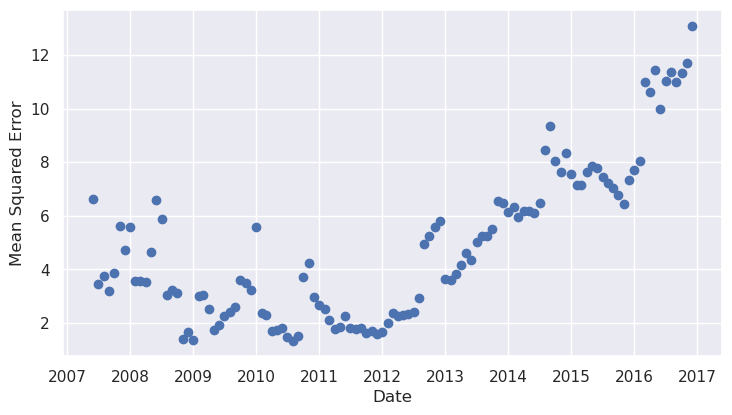

In [58]:
fig_monthly_se, ax_monthly_se = plt.subplots(figsize=BASE_FIG_SIZE)
ax_monthly_se.scatter(mse_mo["date"], mse_mo["se"])
ax_monthly_se.set_ylabel("Mean Squared Error")
ax_monthly_se.set_xlabel("Date")
plt.show()


The observation that the model's performance starts to degrade from 2013 and onwards, despite making predictions on data it has already seen during training, suggests the presence of external factors or evolving conditions that are not explicitly incorporated into the model. These external factors could include changes in economic conditions, regulatory policies, or other unaccounted variables that impact the prediction task.

**Getting a comparison of MSE when trained on the full data set and when trained only on latter data**

In [59]:
print("MSE When trained on the full training set:")
print(mean_squared_error(y_val_single_intr, preds_val_single_intr))

single_intr_regressor.pipeline.fit(
    X_train_single.with_columns(y_train_single_intr)
    .filter(pl.col("year") >= 2014)
    .drop(columns="int_rate"),
    X_train_single.with_columns(y_train_single_intr).filter(pl.col("year") >= 2014)[
        "int_rate"
    ],
)

preds_val_2016 = single_intr_regressor.pipeline.predict(X_val_single)

print("MSE When trained only on 2014-2016 data:")
print(mean_squared_error(y_val_single_intr, preds_val_2016))

MSE When trained on the full training set:
12.928763130190735


MSE When trained only on 2014-2016 data:
12.8533904116089


**A comparison of grade classification metrics when trained on the full training set and only on latter data:**

In [60]:
print("Full training set:")
print(classification_report(y_val_single, preds_lgbm))

best_pipeline_single.fit(
    X_train_single.with_columns(y_train_single)
    .filter(pl.col("year") >= 2014)
    .drop(columns="grade"),
    X_train_single.with_columns(y_train_single).filter(pl.col("year") >= 2014)["grade"],
)

preds_val_2016_grade = best_pipeline_single.predict(X_val_single)

print("Trained only on 2014-2016 data:")
print(classification_report(y_val_single, preds_val_2016_grade))


Full training set:
              precision    recall  f1-score   support

           1       0.65      0.71      0.68     72529
           2       0.48      0.55      0.51    121365
           3       0.52      0.35      0.42    130148
           4       0.26      0.30      0.28     50567
           5       0.17      0.28      0.21     17982
           6       0.14      0.20      0.16      5509
           7       0.26      0.02      0.03      3054

    accuracy                           0.46    401154
   macro avg       0.35      0.34      0.33    401154
weighted avg       0.48      0.46      0.46    401154

Trained only on 2014-2016 data:
              precision    recall  f1-score   support

           1       0.65      0.73      0.69     72529
           2       0.52      0.54      0.53    121365
           3       0.52      0.43      0.47    130148
           4       0.30      0.32      0.31     50567
           5       0.19      0.31      0.24     17982
           6       0.16    

The evidence suggests that the predictions for both grades and interest rates tend to be more accurate when the models are trained on newer data. While the increase in accuracy may not completely offset the temporal effects observed earlier, it does indicate that model performance can benefit from staying up-to-date with more recent training data.

Due to this phenomena the exported models will only be trained on the validation and test sets after all the testing is done (2017-2018 data).

### <a id='toc5_2_'></a>[Feature importance based on SHAP values](#toc0_)

**Grade prediction shap values:**

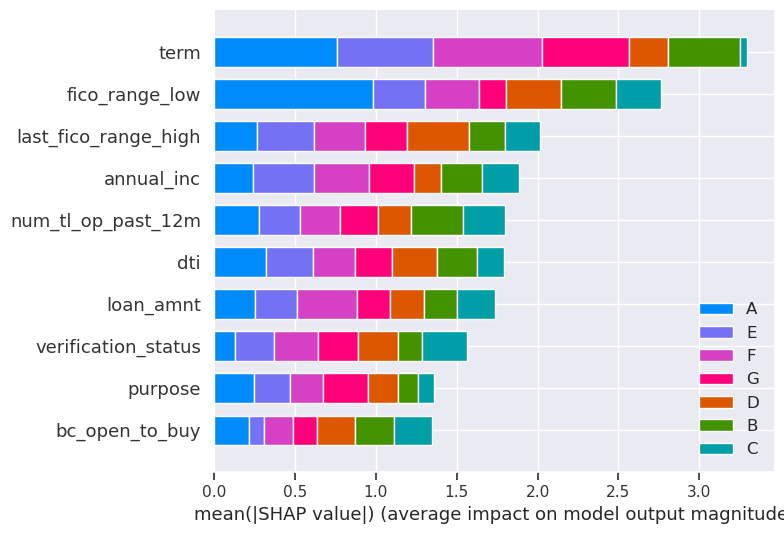

In [61]:
names = (
    best_pipeline_single["preprocess"]
    .transform(X_val_single.sample(1000, seed=1))
    .columns
)
explainer_tree = shap.TreeExplainer(
    best_pipeline_single["model"],
    data=best_pipeline_single["preprocess"]
    .transform((X_val_single.sample(1000, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values_grade = explainer_tree.shap_values(
    best_pipeline_single["preprocess"]
    .transform(X_val_single.sample(1000, seed=1))
    .to_numpy(),
    approximate=True,
)

shap.summary_plot(
    shap_values_grade,
    best_pipeline_single["preprocess"]
    .transform(X_val_single.sample(1000, seed=1))
    .to_numpy(),
    feature_names=names,
    class_names={0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"},
    max_display=10,
)


**Interest rate prediction SHAP values:**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


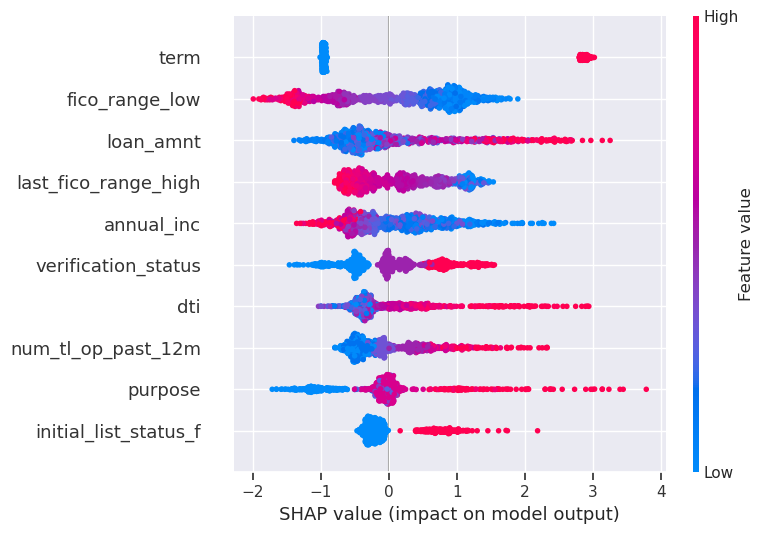

In [62]:
names_single_intr = (
    single_intr_regressor.pipeline["preprocess"]
    .transform(X_val_single.sample(1000, seed=1))
    .columns
)
explainer_single_intr = shap.TreeExplainer(
    single_intr_regressor.pipeline["model"],
    data=single_intr_regressor.pipeline["preprocess"]
    .transform((X_val_single.sample(1000, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values_single_intr = explainer_single_intr.shap_values(
    single_intr_regressor.pipeline["preprocess"]
    .transform(X_val_single.sample(1000, seed=1))
    .to_numpy(),
    approximate=True,
)

shap.summary_plot(
    shap_values_single_intr,
    single_intr_regressor.pipeline["preprocess"]
    .transform(X_val_single.sample(1000, seed=1))
    .to_numpy(),
    feature_names=names_single_intr,
    max_display=10,
)


**Joint Application Interest Model SHAP Values:**

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


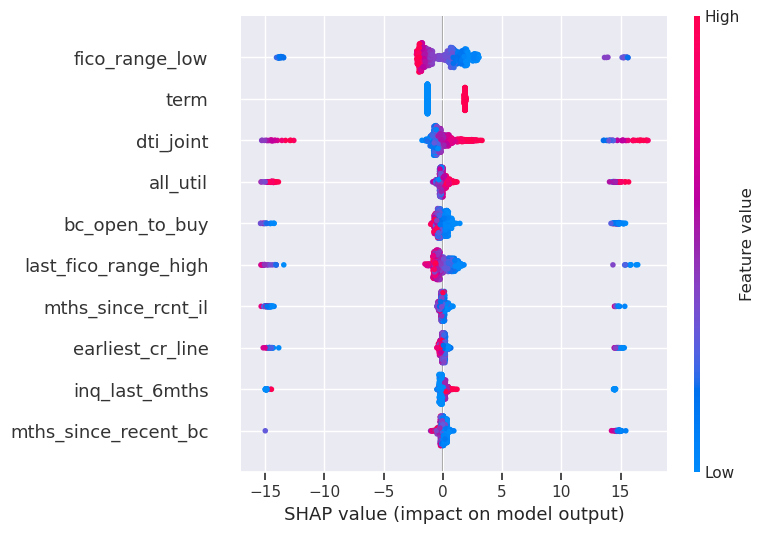

In [63]:
names_joint_intr = (
    joint_intr_regressor.pipeline["preprocess"]
    .transform(X_test_joint.sample(1000, seed=1))
    .columns
)
explainer_joint_intr = shap.TreeExplainer(
    joint_intr_regressor.pipeline["model"],
    data=joint_intr_regressor.pipeline["preprocess"]
    .transform((X_test_joint.sample(1000, seed=1)))
    .to_numpy(),
    model_output="raw",
)

shap_values_joint_intr = explainer_joint_intr.shap_values(
    joint_intr_regressor.pipeline["preprocess"]
    .transform(X_test_joint.sample(1000, seed=1))
    .to_numpy(),
    approximate=True,
)

shap.summary_plot(
    shap_values_joint_intr,
    joint_intr_regressor.pipeline["preprocess"]
    .transform(X_test_joint.sample(1000, seed=1))
    .to_numpy(),
    feature_names=names_joint_intr,
    max_display=10,
)


According to SHAP, the most influential features in determining the model's grade and interest rate predictions included:

1. Term of the loan.
2. FICO range: The range of the applicant's FICO credit score.
3. Loan amount (loan_amnt).
4. Annual income (annual_inc).
5. Debt-to-Income ratio (DTI).
6. Verification Status.
7. Purpose of the loan.
8. Number of accounts opened in past 12 months.

For joint applications similar joint features or features of the second applicant were also influential.

### <a id='toc5_3_'></a>[Final Testing and Exports](#toc0_)

#### <a id='toc5_3_1_'></a>[Single Application Grade Model](#toc0_)

In [64]:
best_pipeline_single.fit(X_val_single, y_val_single)

preds_single_final = best_pipeline_single.predict(X_test_single)
print(classification_report(y_test_single, preds_single_final))


              precision    recall  f1-score   support

           1       0.75      0.58      0.65    119923
           2       0.43      0.44      0.43    121995
           3       0.39      0.41      0.40    108373
           4       0.29      0.32      0.31     57923
           5       0.15      0.24      0.18     15356
           6       0.04      0.07      0.05      2266
           7       0.01      0.05      0.01       421

    accuracy                           0.45    426257
   macro avg       0.29      0.30      0.29    426257
weighted avg       0.48      0.45      0.46    426257



**Exporting the final model:**

In [65]:
best_pipeline_single.fit(
    X_val_single.vstack(X_test_single),
    pl.concat([y_val_single, y_test_single]),
)

joblib.dump(best_pipeline_single, "trained_models/model_single_grade.joblib")

['trained_models/model_single_grade.joblib']

#### <a id='toc5_3_2_'></a>[Joint Application Grade model](#toc0_)

**Testing the model:**

In [66]:
joint_grade_classifier.pipeline.fit(X_val_joint, y_val_joint)

preds_joint_grade_final = joint_grade_classifier.pipeline.predict(X_test_joint)
print(classification_report(y_test_joint, preds_joint_grade_final))


              precision    recall  f1-score   support

           1       0.75      0.77      0.76      6921
           2       0.53      0.53      0.53      8069
           3       0.44      0.52      0.47      7397
           4       0.41      0.39      0.40      4496
           5       0.33      0.11      0.17      1521
           6       0.29      0.09      0.13       275
           7       0.00      0.00      0.00        78

    accuracy                           0.54     28757
   macro avg       0.39      0.34      0.35     28757
weighted avg       0.53      0.54      0.53     28757



The model's accuracy increased when tested on the most recent data. This suggests that the model is adapting well to changing trends and conditions. However, the persistent difficulty in identifying the lowest grade loans indicates that there may be specific challenges or complexities associated with this subset of loan applications.

**Exporting the final model:**

In [67]:
joint_grade_classifier.pipeline.fit(
    X_val_joint.vstack(X_test_joint),
    pl.concat([y_val_joint, y_test_joint]),
)

joblib.dump(joint_grade_classifier.pipeline, "trained_models/model_joint_grade.joblib")

['trained_models/model_joint_grade.joblib']

#### <a id='toc5_3_3_'></a>[Single Application Sub-Grade Model](#toc0_)

**Testing the model on new data:**

In [68]:
best_pipeline_single_sub["model"].model.set_params(**{"num_threads": 6})
best_pipeline_single_sub.fit(X_val_single, y_val_single_subgrade)
preds_single_sub_final = best_pipeline_single_sub.predict(X_test_single)
print(classification_report(y_test_single_subgrade, preds_single_sub_final))
print(f"MSE: {mean_squared_error(y_test_single_subgrade,preds_single_sub_final)}")


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


              precision    recall  f1-score   support

           1       0.53      0.07      0.12     25888
           2       0.28      0.11      0.16     20060
           3       0.20      0.10      0.13     22424
           4       0.16      0.08      0.10     27749
           5       0.13      0.08      0.10     23802
           6       0.08      0.06      0.07     23858
           7       0.08      0.08      0.08     25171
           8       0.07      0.10      0.08     20545
           9       0.09      0.10      0.09     27549
          10       0.08      0.11      0.09     24872
          11       0.07      0.11      0.09     24254
          12       0.07      0.11      0.09     21487
          13       0.08      0.11      0.09     22497
          14       0.08      0.11      0.09     20682
          15       0.08      0.10      0.09     19453
          16       0.06      0.09      0.08     13834
          17       0.06      0.08      0.07     12981
          18       0.07    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


**Exporting the final model:**

In [69]:
best_pipeline_single_sub.fit(
    X_val_single.vstack(X_test_single),
    pl.concat([y_val_single_subgrade, y_test_single_subgrade]),
)

joblib.dump(best_pipeline_single_sub, "trained_models/model_single_sugrade.joblib")

['trained_models/model_single_sugrade.joblib']

#### <a id='toc5_3_4_'></a>[Joint Application Sub-Grade Model](#toc0_)

**Testing the model on new data:**

In [70]:
joint_subgrade_classifier.pipeline["model"].model.set_params(**{"num_threads": 6})
joint_subgrade_classifier.pipeline.fit(X_val_joint, y_val_joint_subgrade)
preds_joint_sub_final = joint_subgrade_classifier.pipeline.predict(X_test_joint)
print(classification_report(y_test_joint_subgrade, preds_joint_sub_final))
print(f"MSE: {mean_squared_error(y_test_joint_subgrade,preds_joint_sub_final)}")


              precision    recall  f1-score   support

           1       0.83      0.23      0.36      1560
           2       0.26      0.19      0.22      1197
           3       0.18      0.18      0.18      1157
           4       0.19      0.12      0.15      1793
           5       0.11      0.13      0.12      1214
           6       0.14      0.12      0.13      1698
           7       0.12      0.11      0.11      1794
           8       0.06      0.10      0.08       984
           9       0.13      0.10      0.12      1934
          10       0.09      0.09      0.09      1659
          11       0.10      0.10      0.10      1674
          12       0.08      0.09      0.09      1526
          13       0.08      0.09      0.08      1504
          14       0.08      0.11      0.10      1316
          15       0.10      0.12      0.11      1377
          16       0.06      0.09      0.07      1019
          17       0.08      0.10      0.09      1044
          18       0.08    

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


**Exporting the model:**

In [71]:
joint_subgrade_classifier.pipeline.fit(
    X_val_joint.vstack(X_test_joint),
    pl.concat([y_val_joint_subgrade, y_test_joint_subgrade]),
)
joblib.dump(
    joint_subgrade_classifier.pipeline, "trained_models/model_joint_subgrade.joblib"
)

['trained_models/model_joint_subgrade.joblib']

#### <a id='toc5_3_5_'></a>[Single Application Interest Rate Model](#toc0_)

**Testing the model on new data:**

In [72]:
single_intr_regressor.pipeline.fit(X_val_single, y_val_single_intr)

preds_single_int_final = single_intr_regressor.pipeline.predict(X_test_single)

print(f"MSE: {mean_squared_error(y_test_single_intr,preds_single_int_final)}")

MSE: 13.57844571333342


**Exporting the model**

In [73]:
single_intr_regressor.pipeline.fit(
    X_val_single.vstack(X_test_single),
    pl.concat([y_val_single_intr, y_test_single_intr]),
)
joblib.dump(single_intr_regressor.pipeline, "trained_models/model_single_intr.joblib")

['trained_models/model_single_intr.joblib']

#### <a id='toc5_3_6_'></a>[Joint Application Interest Rate Model](#toc0_)

**Testing the model**

In [74]:
joint_intr_regressor.pipeline.fit(X_val_joint, y_val_joint_intr)
preds_test_joint_intr = joint_intr_regressor.pipeline.predict(X_test_joint)
print(mean_squared_error(y_test_joint_intr, preds_test_joint_intr))


11.18999929344555


**Exporting the model**

In [75]:
joint_intr_regressor.pipeline.fit(
    X_val_joint.vstack(X_test_joint),
    pl.concat([y_val_joint_intr, y_test_joint_intr]),
)

joblib.dump(joint_intr_regressor.pipeline, "trained_models/model_joint_intr")


['trained_models/model_joint_intr']

#### <a id='toc5_3_7_'></a>[Testing Overview](#toc0_)

When testing the models on the final test set, which was collected from the most recent time range, there was decrease in performance this likely attributable to a combination of two main factors:

1. **Overfitting:** The model may have become overfitted to the training data, resulting in a decrease in its generalization performance on unseen data. Overfitting occurs when the model captures noise or specific patterns in the training data that do not generalize well to new, unseen data.

2. **Changing Trends:** As evident from the temporal analysis of model performance, external factors, such as changes in central bank interest rates and shifts in the popularity or dynamics of the lending platform, can introduce variability and complexity into the data. These evolving trends and external factors may not have been adequately accounted for during model training.

